In [2]:
#!pip install pmdarima

# Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [5]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [6]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [7]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Nuclear Capacity.csv')

In [8]:
df.head()

,Unnamed: 0,"U.S. nuclear capacity, daily (Megawatts)"
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9


In [11]:
df.rename(columns={'Unnamed: 0':'Year-Month','U.S. nuclear capacity, daily (Megawatts)':'Capacity'}, inplace=True)
df.head()

,Year-Month,Capacity
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9


lets see the original dataset then we will split into train and test

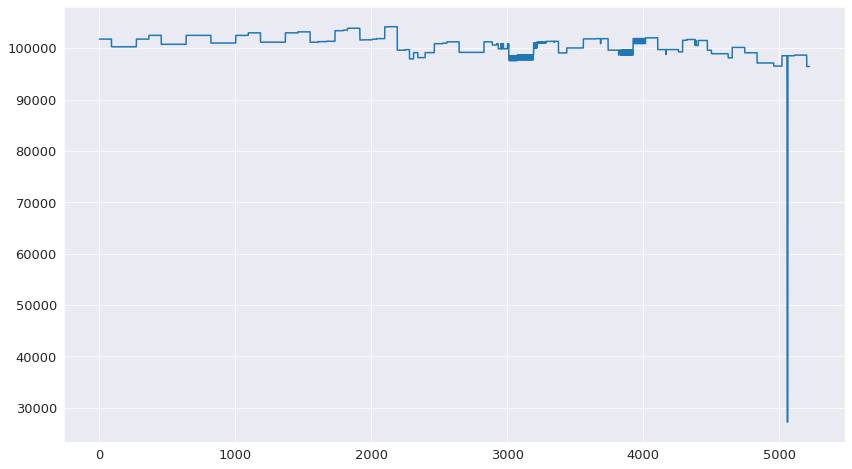

In [12]:
plt.plot(df['Capacity'])

----------------------------------------------------------------------------
- We can see slight downward trend in the dataset and a small variance as well
- Seasonality is visible but lets decide it decompose the series to gain more insights
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [13]:
df.shape

(5225, 2)

In [14]:
df=df['Capacity']

In [15]:
n=int(df.shape[0]*0.7) #test size=30% data
train=df.iloc[:n]
test=df.iloc[n:]


In [16]:
train.shape

(3657,)

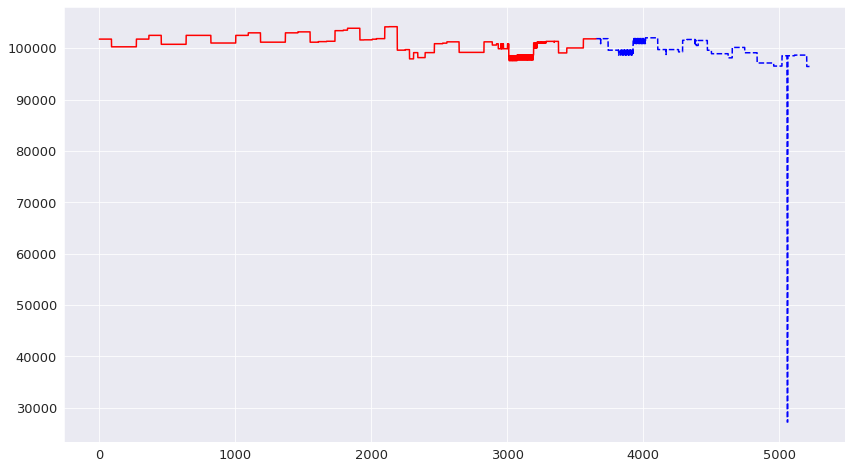

In [17]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [20]:
dicky_fuller_test(df)

ADF Statistic: -5.632946
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data is stationary.


In [21]:
dicky_fuller_test(train) # the data is already stationary

ADF Statistic: -3.591392
p-value: 0.005928
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data is stationary.


- We can conclude that the data is stationary as p- value is very close to 0.05. and for original dataset it is significantly low 


In [24]:
# lets decompose our Time series into its components

In [22]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=12)

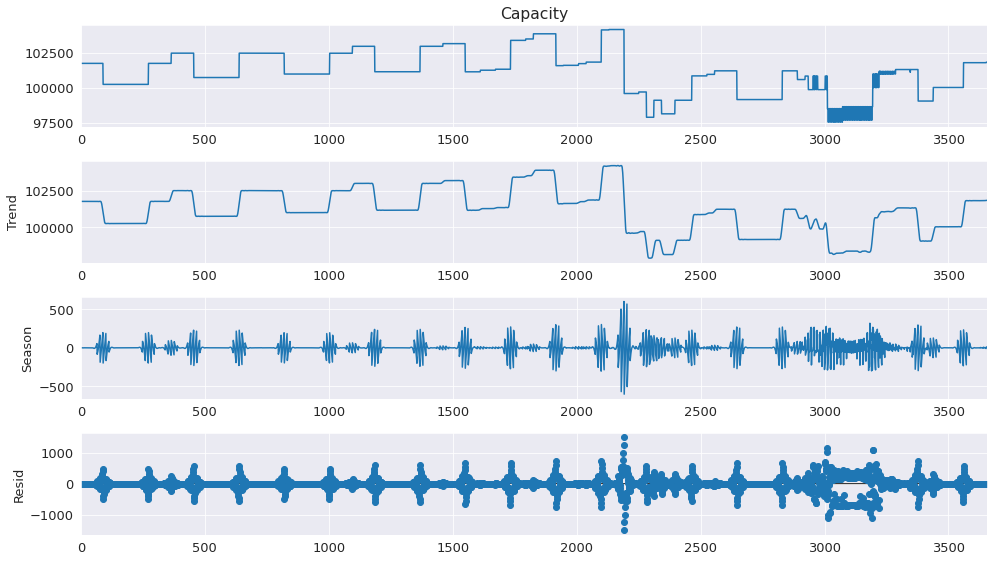

In [23]:
res = stl.fit()
fig = res.plot()

- There is seems to be some trend but no seasonality
- No clear pattern can be seen in Seasonality so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [26]:
df_diff1 = difference(train, interval=1)

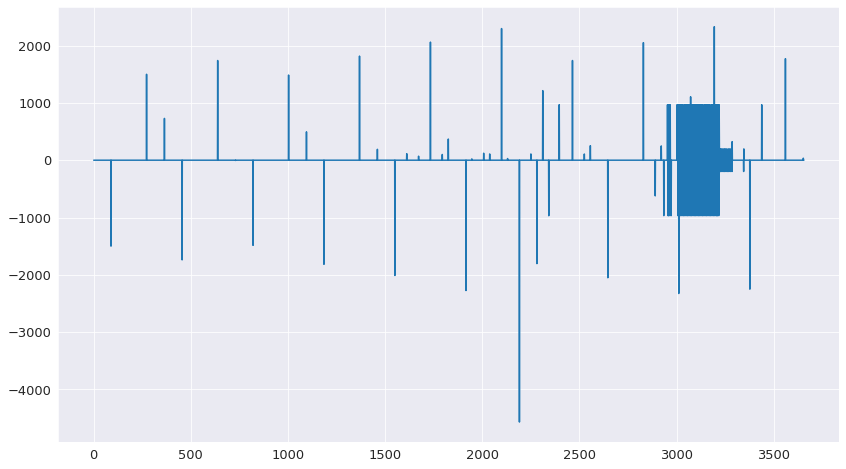

In [27]:
plt.plot(df_diff1)

In [28]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -11.107305
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


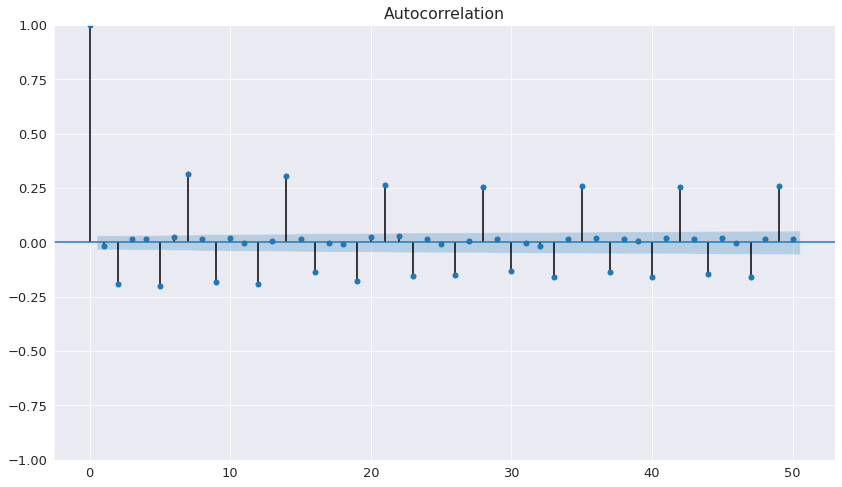

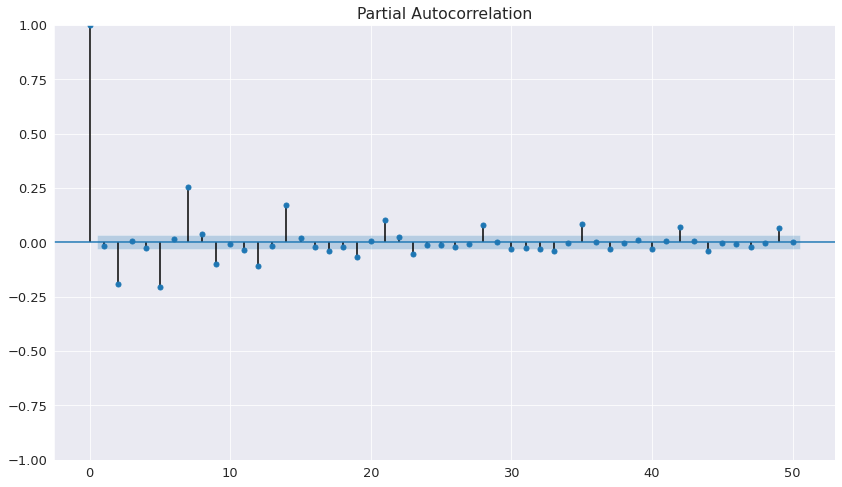

In [29]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff1,lags=50)
fig2 = sm.graphics.tsa.plot_pacf(df_diff1,lags=50)

**Observations**
- From PACF plot we can say that p=1 as after lag 1 most for the lags are not significant
- From ACF plot q=2 or 1 as second lag is very close to significance threshold region 
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality present in the series
- Also, we see Geometric decay in ACF plot and High degree of autocorrelation between adjacent (lag = 1) in PACF plot , so we can say that it is AR(p) process and MA(q) process is not required

In [90]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(2,1,0)) # q=0 as only AR model is required 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:               Capacity   No. Observations:                 3657
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -24784.953
Date:                Sun, 20 Nov 2022   AIC                          49575.906
Time:                        17:53:00   BIC                          49594.518
Sample:                             0   HQIC                         49582.534
                               - 3657                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0181      0.025     -0.723      0.470      -0.067       0.031
ar.L2         -0.1722      0.006    -29.429      0.000      -0.184      -0.161
sigma2      4.512e+04    147.360    306.199      0.0

In [91]:
pred_no=test.shape[0]
pred_no

1568

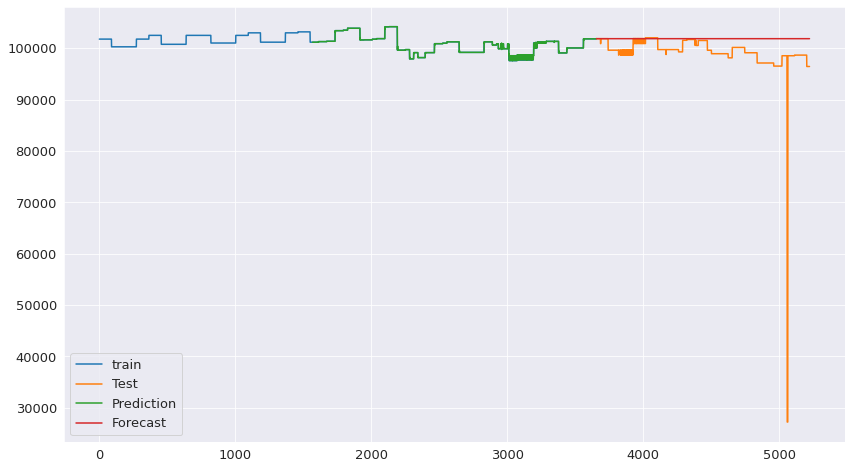

In [92]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just an upward trend because seasonality wasn’t taken into consideration.

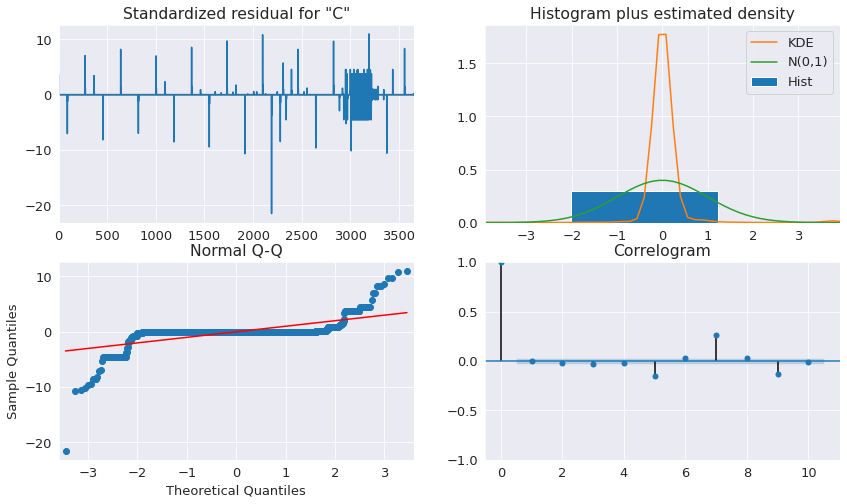

In [93]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
test.shape

(1568,)

In [94]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

5033.389899756621

In [95]:
tsforecast.describe()

count      1568.0
mean     101849.1
std           0.0
min      101849.1
25%      101849.1
50%      101849.1
75%      101849.1
max      101849.1
Name: predicted_mean, dtype: float64

# **Auto-Arima**

In [30]:
from pmdarima import auto_arima

In [31]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=20,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49698.663, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49699.746, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49699.269, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49696.663, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=49649.270, Time=6.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=49579.654, Time=5.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49577.905, Time=1.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49579.713, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=49581.682, Time=3.98 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49575.906, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49697.746, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=49577.714, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=49577.657, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49647.279, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0

In [32]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3657
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -24784.953
Date:                Sun, 20 Nov 2022   AIC                          49575.906
Time:                        17:46:45   BIC                          49594.518
Sample:                             0   HQIC                         49582.534
                               - 3657                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0181      0.025     -0.723      0.470      -0.067       0.031
ar.L2         -0.1722      0.006    -29.429      0.000      -0.184      -0.161
sigma2      4.512e+04    147.360    306.199      0.0

## Forecasting using Auto ARIMA

In [47]:
forecast =pd.DataFrame(arima_model.predict(n_periods=1568),columns=['forecast'],index=test.index)
forecast

,forecast
3657,101849.1
3658,101849.1
3659,101849.1
3660,101849.1
3661,101849.1
...,...
5220,101849.1
5221,101849.1
5222,101849.1
5223,101849.1


In [48]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

,forecast,Capacity
3657,101849.1,101849.1
3658,101849.1,101849.1
3659,101849.1,101849.1
3660,101849.1,101849.1
3661,101849.1,101849.1
...,...,...
5220,101849.1,96434.9
5221,101849.1,96434.9
5222,101849.1,96434.9
5223,101849.1,96434.9


In [49]:
forecast_df.describe()

,forecast,Capacity
count,1568.0,1568.000000
mean,101849.1,99388.216709
std,0.0,4392.194267
min,101849.1,27239.600000
25%,101849.1,98651.300000
50%,101849.1,99609.900000
75%,101849.1,101496.100000
max,101849.1,102016.800000


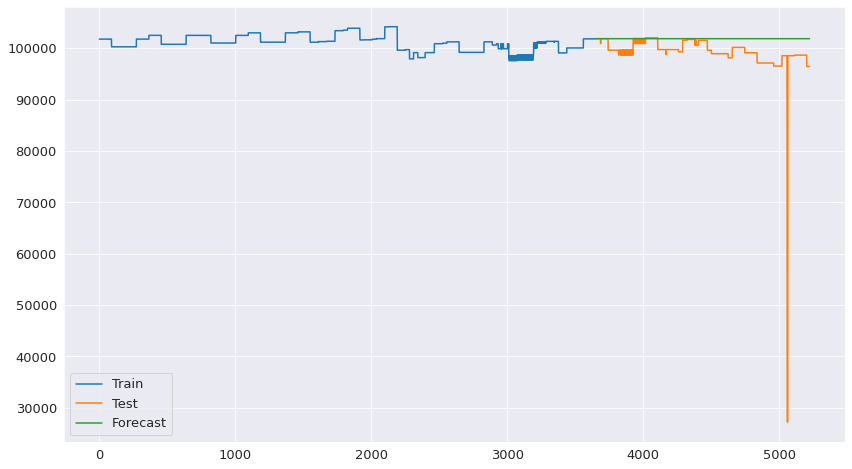

In [50]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

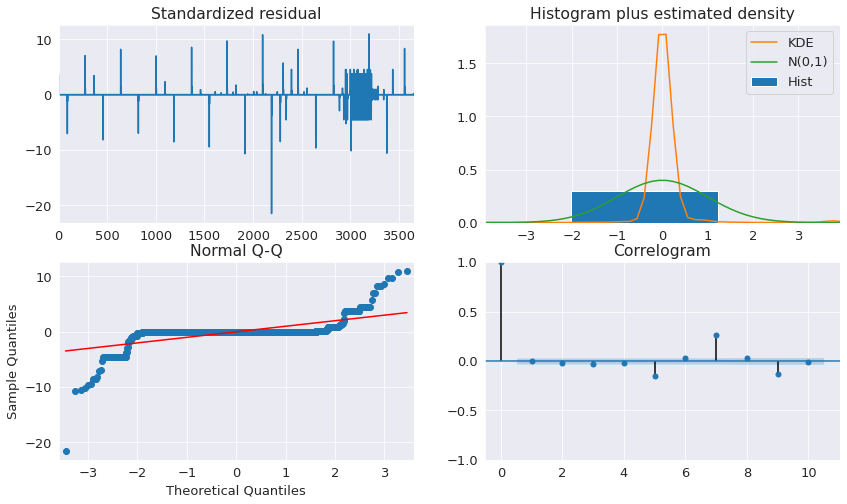

In [37]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

Since our ARIMA model parameters p,d,q=(1,1,0) are same as that AUTO_ARIMA parameters we have got the exact same results 

In [51]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse value: 5033.389899756621


# **Holt-Winter**

In [52]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [53]:
model = Holt(train)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.9714285714285713,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 101764.9,
 'initial_trend': 0.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [54]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:               Capacity   No. Observations:                 3657
Model:                           Holt   SSE                      171230869.134
Optimized:                       True   AIC                          39335.835
Trend:                       Additive   BIC                          39360.652
Seasonal:                        None   AICC                         39335.858
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:49:38
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9714286                alpha                 True
smoothing_trend               0.0001                

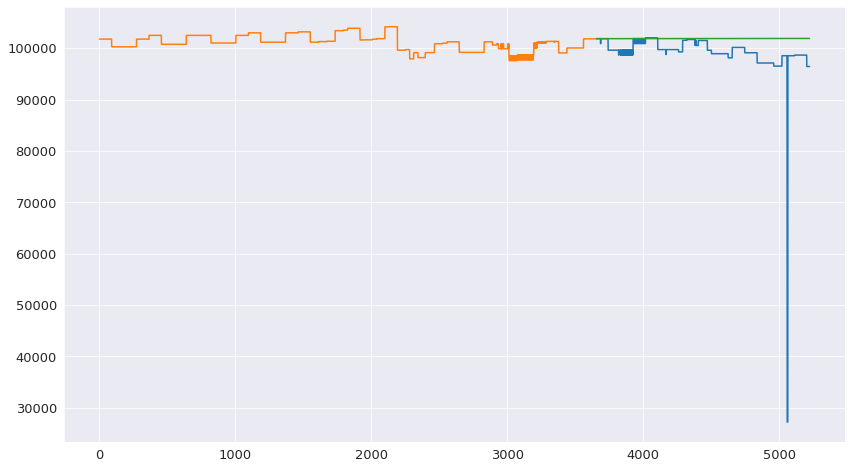

In [57]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(1568))

In [58]:
rmse = mean_squared_error(test, result.forecast(1568), squared=False)
rmse

5048.4670533989865

- As rmse value of holt winters model is 73.64 which is greater than rmse value of AR(54.37) Model, therefore we can say that for this scenario AR model fits better 

In [59]:
# lets also check manually 

In [60]:
rolling = df.rolling(10) # moving average with window 10
type(rolling)

pandas.core.window.rolling.Rolling

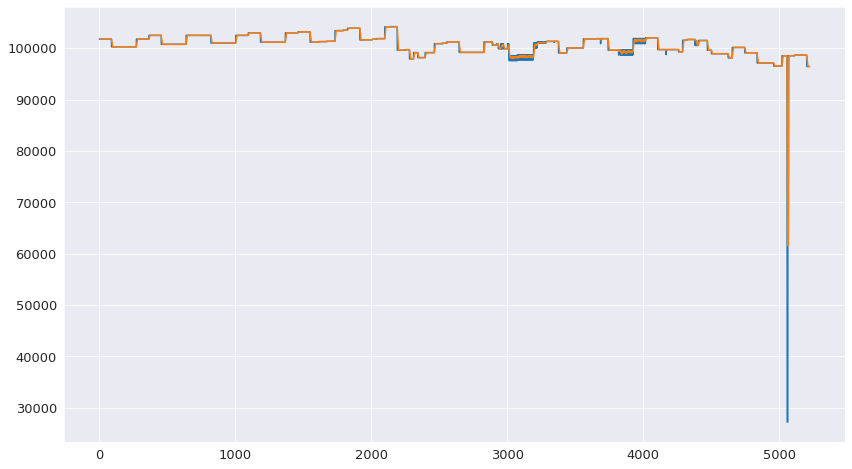

In [61]:
mavg = rolling.mean()
plt.plot(df)
plt.plot(mavg)

In [62]:
# Exponentially Weighted Moving Average or Exponential smoothing

In [63]:
n=1/(2*12)
n

0.041666666666666664

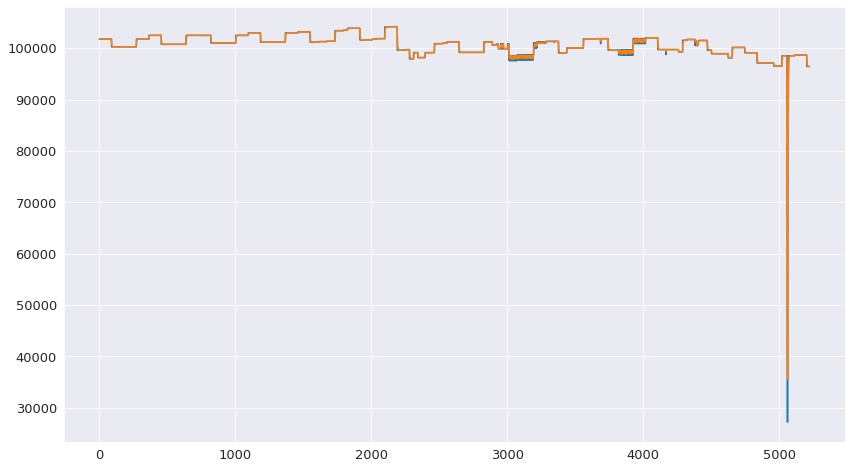

In [64]:
# Try out the following with various values of 'alpha' and evaluate the results
ewma = df.ewm(alpha=0.34, adjust=False).mean() # as we increase alpha value our smoothing curve follows original curve # at 0.9 value it almost matches the original curve
                                              # as we decrease alpha value more smooth curve we get and less it follows original curve
plt.plot(df)
plt.plot(ewma)

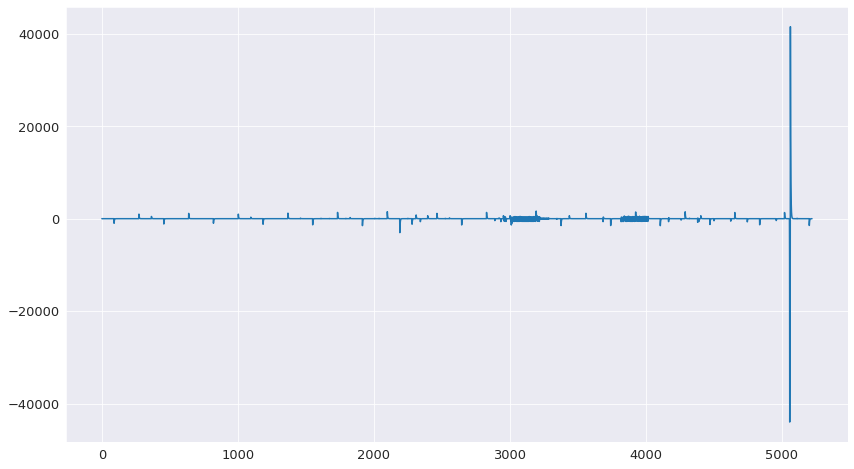

In [65]:
plt.plot(df-ewma) # differencing transformation resulting to de-trended series

Lets apply Holt-Winter manually step by step

In [66]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [67]:
ses = SimpleExpSmoothing(train) # moving average

In [68]:
result = ses.fit(smoothing_level=0.1, optimized=False)

In [69]:
print(result.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:               Capacity   No. Observations:                 3657
Model:             SimpleExpSmoothing   SSE                      586604274.254
Optimized:                      False   AIC                          43834.837
Trend:                           None   BIC                          43847.245
Seasonal:                        None   AICC                         43834.848
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:50:39
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
initial_level             1.0176e+05                

In [79]:
mypred = result.predict(start=1, end=len(df))

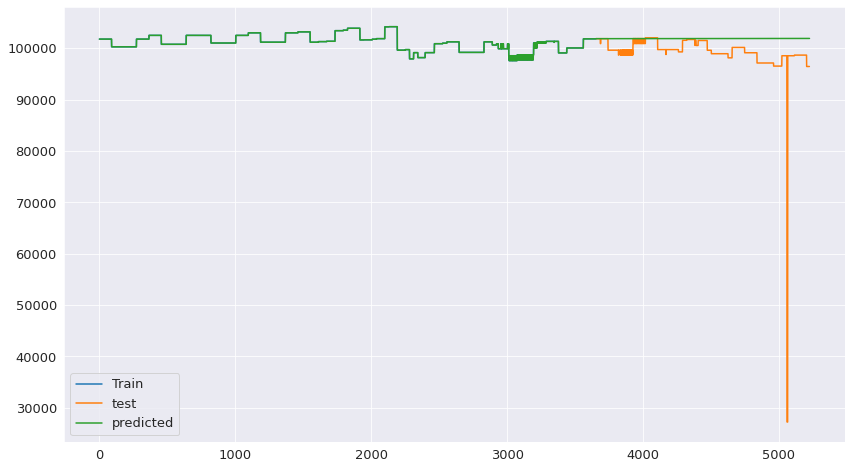

In [80]:
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(mypred, label='predicted')
plt.legend()

In [72]:
result.params

{'smoothing_level': 0.1,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 101764.9,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

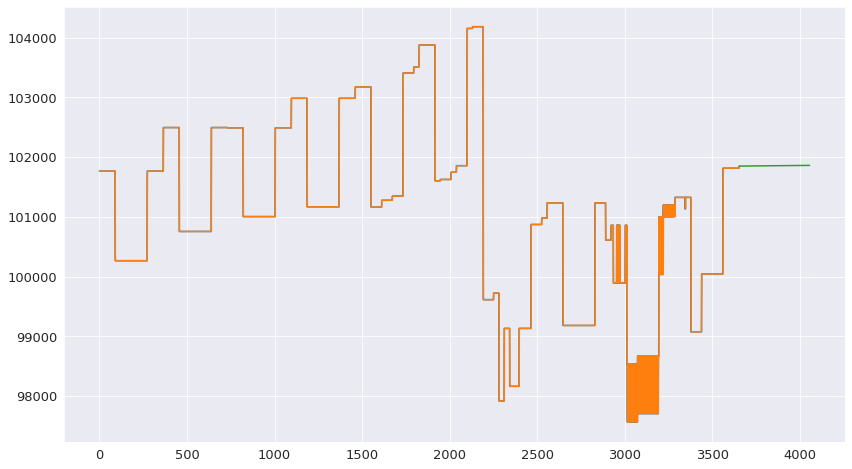

In [81]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(400))

exp smoothing


In [82]:
# Holt's linear trend values

In [83]:
from statsmodels.tsa.holtwinters import Holt

In [84]:
model = Holt(train, exponential=False)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.9714285714285713,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 101764.9,
 'initial_trend': 0.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [85]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:               Capacity   No. Observations:                 3657
Model:                           Holt   SSE                      171230869.134
Optimized:                       True   AIC                          39335.835
Trend:                       Additive   BIC                          39360.652
Seasonal:                        None   AICC                         39335.858
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:51:37
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9714286                alpha                 True
smoothing_trend               0.0001                

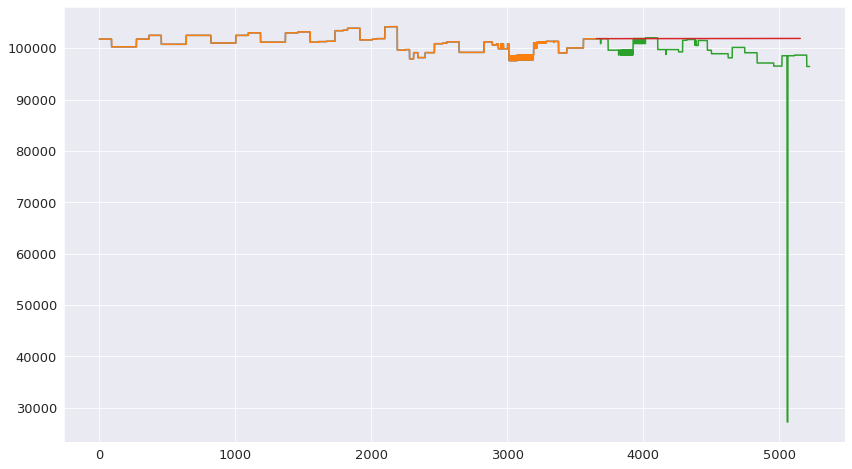

In [89]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(test)
plt.plot(result.forecast(1500))

We can say that its very challenging to predict crude oil prices. The fluctuations in the prices of crude oil are random and are highly dependent on demand and suppy scenerio, which is why we are getting incorrect prediction values  

If we keep the test size to be 20% we get better result in Holt's model as compared to ARIMA as holt model predicts the values as increasing trend and not a flat line 